# import libraries


In [1]:
import tensorflow as tf
import tensorflow.keras.layers as Layers
import numpy as np
import matplotlib.pyplot as plt
import time

from IPython import display

# define parameters

In [2]:
LEARNING_RATE = 0.0001
OPTIMIZER_D = tf.optimizers.Adam(lr=LEARNING_RATE)
OPTIMIZER_G = tf.optimizers.Adam(lr=LEARNING_RATE)
BCE = tf.keras.losses.BinaryCrossentropy(from_logits=True)

INPUT_LENGTH = 64

EPOCHS = 200
BATCH_SIZE = 128

OUTPUT_SIZE = 28


# load data

In [3]:
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, axis=-1).astype('float32')
x_train = (x_train)/255.0
IMAGE_SHAPE = x_train[0].shape

print(x_train.shape)
print(np.max(x_train))

(60000, 28, 28, 1)
1.0


In [4]:
# Batch and shuffle the data
x_train = tf.data.Dataset.from_tensor_slices(x_train)
x_train = x_train.batch(BATCH_SIZE, drop_remainder=True)

# define model

### generator

In [5]:
def generator(input_dim, output_dim):
    model = tf.keras.models.Sequential()

    model.add(Layers.Dense(input_dim*2, input_dim=input_dim))
    model.add(Layers.BatchNormalization())
    model.add(Layers.ReLU())

    model.add(Layers.Dense(input_dim*4))
    model.add(Layers.BatchNormalization())
    model.add(Layers.ReLU())

    model.add(Layers.Dense(input_dim*8))
    model.add(Layers.BatchNormalization())
    model.add(Layers.ReLU())

    model.add(Layers.Dense(output_dim*output_dim, activation='sigmoid'))
    model.add(Layers.Reshape((output_dim,output_dim,1)))
    model.summary()
    return model

### discriminator

In [6]:
def discriminator(hidden_dim, input_shape):
    model = tf.keras.models.Sequential()

    model.add(Layers.Flatten(input_shape=input_shape))
    model.add(Layers.Dense(hidden_dim*4))
    model.add(Layers.LeakyReLU(0.2))
    model.add(Layers.Dense(hidden_dim*2))
    model.add(Layers.LeakyReLU(0.2))
    model.add(Layers.Dense(hidden_dim))
    model.add(Layers.LeakyReLU(0.2))
    model.add(Layers.Dense(1, activation='sigmoid'))
    model.summary()
    return model

# Full model

In [7]:
gen = generator(INPUT_LENGTH, OUTPUT_SIZE)
discr = discriminator(INPUT_LENGTH, (OUTPUT_SIZE, OUTPUT_SIZE, 1))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
re_lu (ReLU)                 (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1

# Define train step

In [8]:
def get_noise(input_dim, num_samples):
    return tf.random.normal((num_samples, input_dim))

In [9]:
def get_discr_loss(gen, discr, real, input_dim, num_samples):
    noise = get_noise(input_dim, num_samples)
    fake_images = gen(noise)
    fake_pred = discr(fake_images)
    real_pred = discr(real)
    fake_loss = BCE(fake_pred, tf.zeros_like(fake_pred))
    real_loss = BCE(real_pred, tf.ones_like(real_pred))
    return real_loss+fake_loss

In [10]:
def get_gen_loss(gen, discr, input_dim, num_samples):
    noise = get_noise(input_dim, num_samples)
    fake_images = gen(noise)
    fake_pred = discr(fake_images)
    gen_loss = BCE(fake_pred, tf.ones_like(fake_pred))
    return gen_loss

In [11]:
@tf.function
def train_step(gen, discr, real, input_dim):
    num_samples = len(real)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:
        gen_loss = get_gen_loss(gen, discr, input_dim, num_samples)
        discr_loss = get_discr_loss(gen, discr, real, input_dim, num_samples)
    gen_grads = gen_tape.gradient(gen_loss, gen.trainable_variables)
    discr_grads = discr_tape.gradient(discr_loss, discr.trainable_variables)
    OPTIMIZER_D.apply_gradients(zip(discr_grads, discr.trainable_variables))
    OPTIMIZER_G.apply_gradients(zip(gen_grads, gen.trainable_variables))
    return (gen_loss, discr_loss)

# Train model

In [12]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


In [13]:
seed = get_noise(INPUT_LENGTH, 16)

In [14]:
def print_weight_matrices(model):
    weights = []
    for l in model.layers:
      if l.trainable == True:
        weights.append(l.get_weights()[0])
    #print(len(weights))
    fig = plt.figure(figsize=(4, 4))
    for i in range(len(weights)):
        plt.subplot(4, 4, i+1)
        plt.imshow(weights[i], cmap='gray')
        plt.axis('off')
    plt.show()

In [15]:
def train(x_train, gen, discr, input_dim, epochs):
    for e in range(epochs):
      start = time.time()
      for image_batch in x_train:
          gen_loss, discr_loss = train_step(gen, discr, image_batch, input_dim)
      # Produce images for the GIF as we go
      display.clear_output(wait=True)
      generate_and_save_images(gen, e + 1, seed)
      # print_weight_matrices(gen)
      # print_weight_matrices(discr)
      print("Loss - gen: {}, discr: {}".format(gen_loss, discr_loss))
      # print("Accuracy - gen: {}, discr: {}".format(gen_acc, discr_acc))
      print ('Time for epoch {} is {} sec'.format(e + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(gen, epochs, seed)


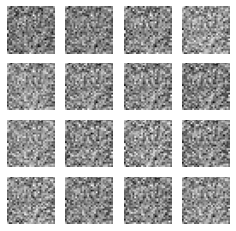

Loss - gen: 0.3132617473602295, discr: 1.006408929824829
Time for epoch 8 is 2.5123989582061768 sec


KeyboardInterrupt: ignored

In [16]:
train(x_train, gen, discr, INPUT_LENGTH, EPOCHS)

# Generate new images

In [ ]:
num_images = 10
noise = get_noise(INPUT_LENGTH, num_images)
generated_images = gen(noise, training=False)*255.0

# View generated images

In [ ]:
plt.imshow(np.squeeze(generated_images[np.random.randint(num_images)]), cmap='gray')